## Value-at-Risk: Using Filtered Historical Simulation

**Functions**

`arch_model`, `ARCHModelResult.std_resid`, `np.percentile`

### Exercise 82
Use a GARCH(1,1) model to construct filtered historical VaR for the S&P 500 and
the EUR/USD exchange rate, using 10 years of data.

**Note**: For simplicity, estimate the model on the full sample, but start the
historical simulation at 25% of the data, and then build the additional forecasts
using a recursive scheme.

In [1]:
import numpy as np
import pandas as pd
from arch import arch_model

sp500 = pd.read_hdf("./data/arch-data.h5", "sp500")
eurusd = pd.read_hdf("./data/arch-data.h5", "eurusd")

sp500_returns = 100 * sp500.SP500.pct_change().dropna()
eurusd_returns = 100 * eurusd.DEXUSEU.pct_change().dropna()

mod = arch_model(sp500_returns, rescale=False)
res = mod.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3269662.2486262713
Iteration:      2,   Func. Count:     15,   Neg. LLF: 12440111094.451752
Iteration:      3,   Func. Count:     23,   Neg. LLF: 4220.707091735658
Iteration:      4,   Func. Count:     31,   Neg. LLF: 4168.552307381477
Iteration:      5,   Func. Count:     37,   Neg. LLF: 3007.7164573296877
Iteration:      6,   Func. Count:     43,   Neg. LLF: 2997.09170575461
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2997.065213352725
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2997.0613460320155
Iteration:      9,   Func. Count:     58,   Neg. LLF: 2997.0607371369097
Iteration:     10,   Func. Count:     63,   Neg. LLF: 2997.0607255161153
Iteration:     11,   Func. Count:     67,   Neg. LLF: 2997.060725515827
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2997.0607255161153
            Iterations: 11
            Function evaluations: 67
            Gradient evaluatio

#### Explanation

We start out by loading the index data, computing percentage returns
and then estimating a GARCH(1,1) on the S&P 500 returns.

In [2]:
std_resid: pd.Series = res.std_resid
forecasts = res.forecast(start=sp500_returns.index[0], reindex=False)

start = int(0.25 * std_resid.shape[0])
std_quantile = std_resid.expanding(min_periods=start).quantile(0.05)


mu = res.params.mu
sigma = np.sqrt(forecasts.variance["h.1"])
q = std_quantile

var_1step = -mu - sigma * q
# Fix alignment since both q and sigma are aligned at time when produced
var_1step = var_1step.dropna()

#### Explanation

The 1-step FHS 5% VaR requires three inputs: the conditional mean and
variance and the quantile of the standardized residuals.  The mean is
constant and so can be determined from the model parameters. The 1-step
ahead variance can be computed using the `forecast` method. The forecast
variance is returns in a DataFrame in the column `h.1`. This value is
origin-aligned so that the value in position $m$ is the forecast for
period $m+1$.  Finally, we need to quantile of the standardized residuals.
This is computed on an expanding basis using the same method that was used
to construct HS VaR in the previous lesson. 

Finally, these are combined to produce the VaR.  Note that we use
$-\mu - \sigma q_{0.05}$ since we want the VaR to be positive in most
situations and $q_{0.05}$ is usually negative.

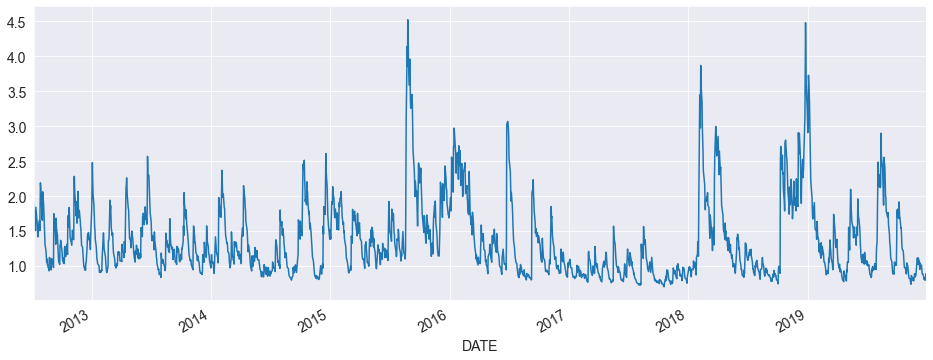

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("font", size=14)
fig, ax = plt.subplots(1, 1)
var_1step.plot(ax=ax)
xl = ax.set_xlim(var_1step.index.min(), var_1step.index.max())

#### Explanation
Here we plot the one-step ahead VaR.


In [4]:
# Use a RandomState for reproducibility
rs = np.random.RandomState([738492843, 438248394])
# The first date
loc = start
# Arrays to hold the simulated variance and returns
variances = np.empty((1000, 5))
sim_eps = np.empty((1000, 5))
# Simulation will use all of the parameters
mu, omega, alpha, beta = res.params
# Loop over the horizon, 5
for i in range(5):
    # Simulate standardized residuals (e) from the empirical distribution
    sim_e = rs.choice(res.std_resid.iloc[:loc], size=1000)
    if i == 0:
        # For 0 we use the 1-step variance forecast
        variances[:, 0] = forecasts.variance["h.1"].iloc[loc]
    else:
        # For 2...5 we simulate the variance
        variances[:, i] = (
            omega + alpha * sim_eps[:, i - 1] ** 2 + beta * variances[:, i - 1]
        )
    # The simulated residual is then the produce of the variance and the
    # simulated standardized residuals.
    sim_eps[:, i] = np.sqrt(variances[:, i]) * sim_e
# Finally, the simulate returns include the mean
sim_rets = mu + sim_eps
# The 5-day return is then the sum across time (axis=1)
rets_5 = sim_rets.sum(axis=1)
# The VaR is then determined using the 5% quantile
fhs_var = -np.percentile(rets_5, 5)
fhs_var

3.6644268691582016

#### Explanation

Multi-step VaR is harder.  We need to simulate returns for $h$ days and then take
the quantile of the simulated returns. While `arch` can do this for us, it is
instructive to manually implement the steps. We start with a single day,
and then wrap that in a loop to compute the 5-day VaR for the entire sample.

In [5]:
nobs = sp500_returns.shape[0]
var_5step = np.full(nobs, np.nan)
for j in range(start, nobs):
    if j % 250 == 0:
        print(f"Remaining: {nobs - j}")
    sub_std_resid = res.std_resid.iloc[:j]
    sigma2_t = forecasts.variance["h.1"].iloc[j]
    for i in range(5):
        sim_e = rs.choice(sub_std_resid, size=1000)
        if i == 0:
            variances[:, 0] = sigma2_t
        else:
            variances[:, i] = (
                omega + alpha * sim_eps[:, i - 1] ** 2 + beta * variances[:, i - 1]
            )
        sim_eps[:, i] = np.sqrt(variances[:, i]) * sim_e
    sim_rets = mu + sim_eps
    rets_5 = sim_rets.sum(1)
    var_5step[j] = -np.percentile(rets_5, 5)

Remaining: 1760
Remaining: 1510


Remaining: 1260
Remaining: 1010
Remaining: 760


Remaining: 510
Remaining: 260


Remaining: 10


#### Explanation
We can construct the 5-step ahead forecasts by simulating the model forward.
Note that the first out-of-sample variance is known at time $t$, and so we
only simulate for `i > 0`. Once we have the simulated $\epsilon$, we then then
simulate the 5 returns and the total return over 5 days using `sum`. Finally,
we use `percentile` to find the 5% quantile. 

In [6]:
var_5step = pd.Series(var_5step, index=sp500_returns.index)
var_5step = var_5step.shift(5)

#### Explanation

Finally, we shift it by 5 places so that the forecast lines up with the point
where we will evaluate it.

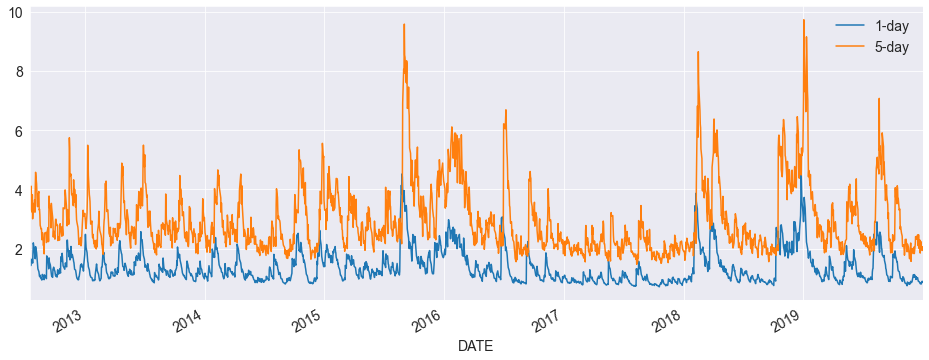

In [7]:
value_at_risks = pd.concat([var_1step, var_5step], axis=1).dropna()
value_at_risks.columns = ["1-day", "5-day"]
ax = value_at_risks.plot(legend=False)
ax.set_xlim(value_at_risks.index.min(), value_at_risks.index.max())
lgd = ax.legend(frameon=False)

#### Explanation

We can plot the 1- and 5-day Value-at-Risks.

In [8]:
def fhs_var(params, std_resid, one_step_forecast, loc, random_state, horizon):
    variances = np.empty((1000, horizon))
    sim_eps = np.empty((1000, horizon))
    mu, omega, alpha, beta = params

    for i in range(horizon):
        sim_e = random_state.choice(std_resid.iloc[:loc], size=1000)
        if i == 0:
            variances[:, 0] = one_step_forecast.iloc[loc]
        else:
            variances[:, i] = (
                omega + alpha * sim_eps[:, i - 1] ** 2 + beta * variances[:, i - 1]
            )
        sim_eps[:, i] = np.sqrt(variances[:, i]) * sim_e
    sim_rets = mu + sim_eps
    rets_horizon = sim_rets.sum(1)
    return -np.percentile(rets_horizon, 5)

#### Explanation

Finally, we generalize the code above to allow simulation over any `horizon`.
The code is virtually identical to the 5-step forecasts except that it has
been wrapped in a function.

In [9]:
var_10step = np.full(nobs, np.nan)
forecast_var = forecasts.variance["h.1"]
cond_var = res.conditional_volatility ** 2
horizon = 10
for loc in range(start, nobs):
    if loc % 250 == 0:
        print(f"Remaining: {nobs - loc}")
    var_10step[loc] = fhs_var(res.params, res.std_resid, forecast_var, loc, rs, horizon)

Remaining: 1760


Remaining: 1510


Remaining: 1260


Remaining: 1010


Remaining: 760


Remaining: 510


Remaining: 260


Remaining: 10


#### Explanation

We can use the function to produce the forecasts with a basic loop.

In [10]:
var_10step = pd.Series(var_10step, index=sp500_returns.index)
var_10step = var_10step.shift(10)

#### Explanation

We shift to the evaluation point. 

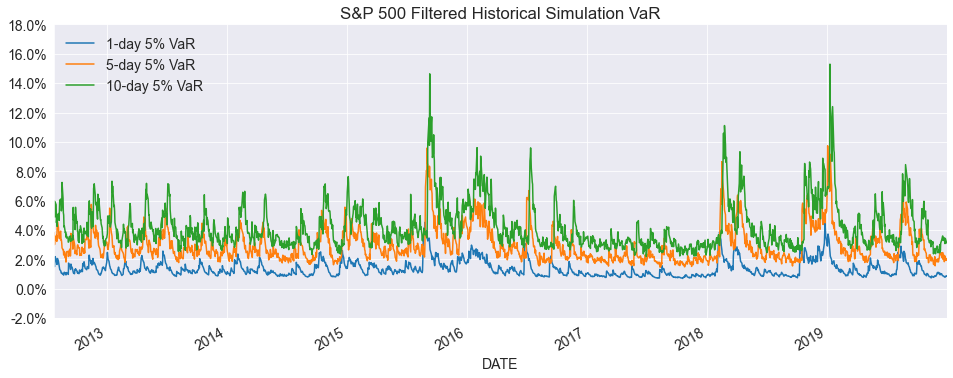

In [11]:
value_at_risks = pd.concat([var_1step, var_5step, var_10step], axis=1).dropna()
value_at_risks.columns = ["1-day 5% VaR", "5-day 5% VaR", "10-day 5% VaR"]
ax = value_at_risks.plot(legend=False)
plt.legend(frameon=False)
ax.set_yticks(ax.get_yticks())  # Set to avoid a warning
ax.set_yticklabels([f"{tick}%" for tick in ax.get_yticks()])
ax.set_xlim(value_at_risks.index.min(), value_at_risks.index.max())
title = ax.set_title("S&P 500 Filtered Historical Simulation VaR")

#### Explanation

Finally we can plot all three Value-at-Risks.

In [12]:
mod = arch_model(eurusd_returns, rescale=False)
res = mod.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 16533289692.829172
Iteration:      2,   Func. Count:     15,   Neg. LLF: 5445097850.32946
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1912.2871665256762
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1890.8325129303448
Iteration:      5,   Func. Count:     34,   Neg. LLF: 3939.7785373003035
Iteration:      6,   Func. Count:     40,   Neg. LLF: 3470.6583358427197
Iteration:      7,   Func. Count:     49,   Neg. LLF: 1921.9252616735548
Iteration:      8,   Func. Count:     57,   Neg. LLF: 1891.1019664386147
Iteration:      9,   Func. Count:     63,   Neg. LLF: 1886.4203194732913
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1886.4203017105333
Iteration:     11,   Func. Count:     73,   Neg. LLF: 1886.4203000038017
Iteration:     12,   Func. Count:     77,   Neg. LLF: 1886.420300003895
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1886.4203000038017
            Iterat

#### Explanation

##### EUR/USD Value-at-Risk

We can repeat the VaR calculation for the EUR/USR return using the function.

In [13]:
forecasts = res.forecast(start=eurusd_returns.index[0])
forecast_var = forecasts.variance["h.1"]
eurusd_var = {}
nobs = eurusd_returns.shape[0]
start = int(0.25 * nobs)
index = eurusd_returns.index
for horizon in (1, 5, 10):
    temp = np.full(nobs, np.nan)
    for loc in range(start, nobs):
        if loc % 500 == 0:
            print(f"Horizon: {horizon}, Remaining: {nobs - loc}")
        temp[loc] = fhs_var(res.params, res.std_resid, forecast_var, loc, rs, horizon)
    eurusd_var[f"{horizon}-day 5% VaR"] = pd.Series(temp, index=index)
eurusd_var = pd.DataFrame(eurusd_var).dropna()

Horizon: 1, Remaining: 1501


c:\git\arch\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Horizon: 1, Remaining: 1001
Horizon: 1, Remaining: 501


Horizon: 1, Remaining: 1


Horizon: 5, Remaining: 1501


Horizon: 5, Remaining: 1001


Horizon: 5, Remaining: 501


Horizon: 5, Remaining: 1


Horizon: 10, Remaining: 1501


Horizon: 10, Remaining: 1001


Horizon: 10, Remaining: 501


Horizon: 10, Remaining: 1


C:\Users\kevin\AppData\Local\Temp/ipykernel_32264/2499887317.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{tick}%" for tick in ax.get_yticks()])


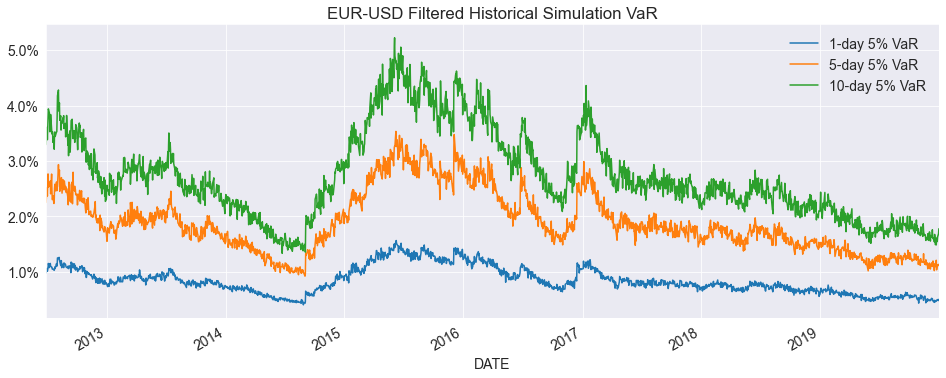

In [14]:
ax = eurusd_var.plot(legend=False)
plt.legend(frameon=False)
ax.set_yticklabels([f"{tick}%" for tick in ax.get_yticks()])
ax.set_xlim(eurusd_var.index.min(), eurusd_var.index.max())
title = ax.set_title("EUR-USD Filtered Historical Simulation VaR")

#### Explanation

We start by using the function to compute the FHS VaR for the EUR-USD rate for
all 3 horizons. We plot both VaRs. Finally, we save the VaRs to use in a later
lesson.


In [15]:
with pd.HDFStore("./data/fhs-var.h5", mode="w") as hdf:
    hdf.put("sp500_var", value_at_risks)
    hdf.put("eurusd_var", eurusd_var)